In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from cytograph.visualization import scatterm
from cytograph.species import Species
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [2]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/revision'

In [3]:
# get ncRNA gene names
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    accession_dict = dict(zip(
        pd.Series(ds.ra.Accession).str.split('.').str[0],
        np.arange(ds.shape[0])
    ))
    ncRNA_genes = np.loadtxt('../202204/ncRNA.txt', dtype='object')
    accession_ix = np.array([accession_dict.get(x, '') for x in ncRNA_genes])
    accession_ix = accession_ix[accession_ix != ''].astype('int')
    ncRNA_genes = ds.ra.Gene[accession_ix]

In [4]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [6]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

# Fig. S7-8 (now Fig. S12-13) Donor colors

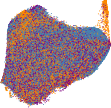

In [298]:
donor_color = {
    'H18.30.001': 'grey',
    'H18.30.002': 'steelblue',
    'H19.30.001': 'darkorange',
    'H19.30.002': 'purple'
}

plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

    labels = labels = np.array([donor_color[x] for x in ds.ca.Donor])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/oligo_donor.pdf', dpi=300)

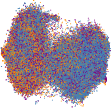

In [299]:
donor_color = {
    'H18.30.001': 'grey',
    'H18.30.002': 'steelblue',
    'H19.30.001': 'darkorange',
    'H19.30.002': 'purple'
}

plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = labels = np.array([donor_color[x] for x in ds.ca.Donor])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/opc_donor.pdf', dpi=300)

# Fix inverted Fig. S10A (now S15A)

In [449]:
k = 2
model = tt.LDAModel.load(f'/proj/human_adult/20220222/harmony/analysis/LDA/astrocytes/{k}/model.bin')
cells = np.loadtxt(f'/proj/human_adult/20220222/harmony/analysis/LDA/astrocytes/{k}/cells.txt').astype('int')
transformed = np.vstack([doc.get_topic_dist() for doc in model.docs])
transformed.shape

(155025, 2)

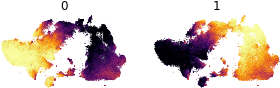

In [450]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/astrocytes.loom', 'r') as ds:

    plt.figure(None, (16, 16))
    gs = plt.GridSpec(6, 6)

    xy = ds.ca.TSNE[cells]
    
    for i in range(k):
        ax = plt.subplot(gs[i])
        plt.scatter(xy[:, 0], xy[:, 1], c=transformed[:, i], s=0.5, lw=0, rasterized=True, cmap='inferno_r')
        plt.axis('off')
        ax.set_aspect('equal')
        plt.title(i)
        plt.margins(0.01, 0.01)

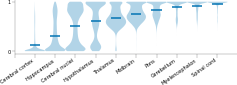

In [452]:
plt.figure(None, (4, 1))

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))
    
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/astrocytes.loom', 'r') as ds:
        
        labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])
        data = [transformed[:, 0][labels == x] for x in list(color_dict.keys())]
        
plt.violinplot(data, showmeans=True, showextrema=False, widths=1)
plt.xticks(range(len(data) + 1), [''] + list(color_dict.keys()), rotation=35, ha='right', fontsize=5)
plt.yticks(fontsize=5)
plt.savefig(f'{figure_folder}/topics_whitematter_type_region.pdf', dpi=300)

# Fig. 3E (now 3D): Reshape subclusters vs clusters

In [119]:
# number of clusters vs number of subclusters for each supercluster

clusters = []
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    is_neuron = pd.Series(ds.ca.Punchcard).str.startswith('harmony_A').to_numpy()
    punchcards = np.unique(ds.ca.Punchcard[is_neuron])
    punchcard_attr = ds.ca.Punchcard
    for card in punchcards:
        clusters.append(
            len(np.unique(ds.ca.Clusters[punchcard_attr == card]))
        )
        
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Punchcard))

fine_clusters = []
with loompy.connect('/proj/human_adult/20220222/harmony/by_cluster/data/Pool.loom', 'r') as ds:
    punchcard_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    for card in punchcards:
        fine_clusters.append(
            len(np.unique(ds.ca.Clusters[punchcard_attr == card]))
        )
    

In [122]:
np.array(fine_clusters)[np.argsort(fine_clusters)]

array([  21,   26,   34,   38,   40,   47,   55,   64,   72,   85,   96,
        102,  109,  116,  138,  139,  143,  155,  180,  211, 1145])

In [123]:
1145 - 211

934

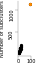

In [130]:
plt.figure(None, (0.25, 1))
ax = plt.subplot(111)
# plt.plot(np.unique(clusters), np.poly1d(np.polyfit(clusters, fine_clusters, 1))(np.unique(clusters)), linestyle='dashed', color='gray')
plt.scatter(clusters, fine_clusters, s=5, color='black')
plt.scatter(clusters[0], fine_clusters[0], s=5, color='darkorange')
plt.margins(x=0.1)
plt.xticks(fontsize=5)
plt.yticks([500, 1000], fontsize=5, rotation=90)
plt.ylabel('Number of subclusters', fontsize=5)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.savefig(f'{figure_folder}/scatter_num_clusters.pdf', dpi=300)

harmony_A_A 2336.0
harmony_A_B 13366.5
harmony_A_C_Clean 26860.0
harmony_A_D 5779.0
harmony_A_E_Clean 681.0
harmony_A_F_Clean 6163.0
harmony_A_G_Clean 10065.0
harmony_A_H_Clean 4507.0
harmony_A_I_Clean 4421.0
harmony_A_J_Clean 7801.0
harmony_A_K_Clean_Clean 3156.0
harmony_A_L_Clean 639.5
harmony_A_M 6000.0
harmony_A_N_Clean_Clean 3704.5
harmony_A_O_Clean 8378.0
harmony_A_P_Clean 1343.0
harmony_A_Q_Clean 2974.5
harmony_A_R_Clean 1508.0
harmony_A_S_Clean 8210.0
harmony_A_T 1553.0
harmony_A_U 3398.5


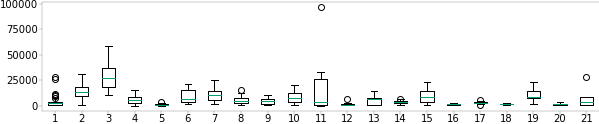

In [131]:
# number of clusters vs number of subclusters for each supercluster

with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Punchcard))

cluster_size = []
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    with loompy.connect(f'{folder}/Pool.agg.loom', 'r') as dsagg:
        punchcard_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
        for card in punchcards:
            punchcard_clusters = np.unique(ds.ca.Clusters[punchcard_attr == card])
            cluster_size.append(
                dsagg.ca.NCells[pd.Series(dsagg.ca.Clusters).isin(punchcard_clusters)]
            )
            print(card, np.median(cluster_size[-1]))

plt.figure(None, (10, 2))
plt.boxplot(cluster_size)
plt.show()

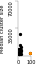

In [132]:
plt.figure(None, (0.25, 1))
ax = plt.subplot(111)
plt.scatter(clusters, [np.median(x) for x in cluster_size], s=5, color='black')
plt.scatter(clusters[0], [np.median(x) for x in cluster_size][0], s=5, color='darkorange')
plt.margins(x=0.1)
plt.xticks(fontsize=5)
plt.yticks([35000, 70000], fontsize=5, rotation=90)
plt.ylabel('Median cluster size', fontsize=5)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.savefig(f'{figure_folder}/scatter_sizes.pdf', dpi=300)